<a href="https://colab.research.google.com/github/ritviksrivastava/newt/blob/master/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VARIATIONAL AUTOENCODER**

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import warnings; 
warnings.simplefilter('ignore')
print(tf.__version__)

1.12.0-rc2


Next, we import the dataset we will be working with that is the MNIST dataset. 

In [9]:
mnist = input_data.read_data_sets('MNIST_data', one_hot =True)
dim_input = mnist.train.images[0].shape[0]
num_train = mnist.train.num_examples
print(dim_input, num_train)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
784 55000


Next, we insert a class declaration by the name of vae()

In [0]:
class vae(object):
  
    def __init__(self, learning_rate = 1e-3, n_batch = 100, n_hidden = 12):
        self.learning_rate = learning_rate
        self.n_batch = n_batch
        self.n_hidden = n_hidden
        #self.build_encoder() ###Builds the model
        self.x =  tf.placeholder(tf.float32, [None, dim_input])
        self.z = tf.placeholder(tf.float32, [None, n_hidden])
        self.build_encoder(self.x)
        self.build_decoder(self.z)
        self.build_model()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def build_encoder(self, x):
        #We bulid a single layer network to encode the mean and the standard_dev
        #Define the hidden layer to be hlayer
        hlayer_enc = keras.layers.Dense(340, activation ='relu')(x)
        mu = keras.layers.Dense(self.n_hidden)(hlayer_enc)
        log_sigma_sq = keras.layers.Dense(self.n_hidden)(hlayer_enc)
        sigma_sq = tf.exp(log_sigma_sq)
        sigma = tf.sqrt(sigma_sq)
        
        return mu, log_sigma_sq, sigma_sq, sigma
      
    def build_decoder(self, z):
        #Next, we build the decoder network with the same number of hidden units 
        #Here out_logit denotes the layer just before the sigmoid normalization
        hlayer_dec = keras.layers.Dense(340, activation='relu')(z)
        self.out_logit = keras.layers.Dense(dim_input)(hlayer_dec)
        self.out_final = tf.sigmoid(self.out_logit)
        return self.out_logit, self.out_final
      
    def build_model(self):
        #Define the loss and the optimizer, both the reconstruction loss 
        #as well as the KL divergence loss between the diagonal gaussian and 
        # N(0,1) 
        #self.x =  tf.placeholder(tf.float32, [None, dim_input])
        self.mu, self.log_sigma_sq, self.sigma_sq, self.sigma = self.build_encoder(self.x)
        self.z = tf.random_normal([self.n_hidden], mean = self.mu, stddev = self.sigma)
        self.out_logit, self.out_final = self.build_decoder(self.z)
        #Next, we define the latent_loss (the KL divergence) and the
        #reconstruction loss between out_final and self.x
        latent_loss = -0.5*tf.reduce_sum(1+ self.log_sigma_sq-tf.square(self.mu) -self.sigma_sq, 1)
        self.latent_loss  = tf.reduce_mean(latent_loss)
        reconstruction_error = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits =self.out_logit, labels=self.x),1)
        self.reconstruction_loss = tf.reduce_mean(reconstruction_error)
        self.total_loss = tf.reduce_mean(latent_loss + reconstruction_error)
        #Now, define the optimizer
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)
        
    def calc_var(self, x):
        #Here, we calculate the various losses defined above
        _, total_loss, reconstruction_loss, latent_loss = self.sess.run([self.optimizer, 
                     self.total_loss, self.reconstruction_loss, self.latent_loss],feed_dict = {self.x:x})
        return total_loss, reconstruction_loss, latent_loss
      
    def reconst_im(self, x):
        #Here given the input image , we would like to have its reconstruction x'
        x_recon = self.sess.run(self.out_final, feed_dict ={self.x:x})
        return x_recon
      
    def project_z_to_out(self, z):
        #Here given the latent space representation, we would like to have the final
        # reconstructued image out_final through the generator network
        x_recon = self.sess.run(self.out_final, feed_dict ={self.z:z})
        return x_recon
    
    def project_x_to_z(self, x):
        #Here we need the latent representation of x in the z space
        z = self.sess.run(self.z, feed_dict = {self.x:x})
        return z
        

Now, we need to define the training method as well as create the model. 

In [11]:
    def fit_model(lr, n_batch, num_epoch, n_h):
        new_model = vae(lr, n_batch, n_h)
        for i in range(num_epoch):
            for num in range(num_train // n_batch):
                new_batch = mnist.train.next_batch(n_batch)
                tot_loss, recon_loss, lat_loss = new_model.calc_var(new_batch[0])
            if i % 5 == 0:
                  print('[Epoch {}] Loss: {}, Recon loss: {}, hidden loss: {}'.format(
                         i, tot_loss, recon_loss, lat_loss))
        print('Finished')     
        return new_model
    
    new_model  = fit_model(lr = 0.001, n_batch = 100, num_epoch=100, n_h =12)

[Epoch 0] Loss: 142.07008361816406, Recon loss: 125.47894287109375, hidden loss: 16.59113311767578
[Epoch 5] Loss: 115.69823455810547, Recon loss: 97.08611297607422, hidden loss: 18.61211585998535
[Epoch 10] Loss: 114.5910873413086, Recon loss: 94.57945251464844, hidden loss: 20.011640548706055
[Epoch 15] Loss: 115.0011215209961, Recon loss: 97.03202056884766, hidden loss: 17.969114303588867
[Epoch 20] Loss: 113.45846557617188, Recon loss: 93.23175811767578, hidden loss: 20.22670555114746
[Epoch 25] Loss: 113.07380676269531, Recon loss: 93.08809661865234, hidden loss: 19.985706329345703
[Epoch 30] Loss: 109.98178100585938, Recon loss: 89.816650390625, hidden loss: 20.165109634399414
[Epoch 35] Loss: 112.76919555664062, Recon loss: 91.79837799072266, hidden loss: 20.970802307128906
[Epoch 40] Loss: 107.55809783935547, Recon loss: 86.06043243408203, hidden loss: 21.497661590576172
[Epoch 45] Loss: 104.70429992675781, Recon loss: 83.01824951171875, hidden loss: 21.686052322387695
[Epoch 5

Now, that we have trained our model. Let us compare the original image **x** with the recontructed image from the network. 
**Q1)** Can we train the network usin some other metric/loss? Ex: What happens if instead of the reconstruction loss we use the latent loss to optimize the model?
**Q2)** What if we were to define some other metric for latent_loss? Ex: Cluster the points using the labels from the original MNIST dataset. And then compare the labels of the points within these clusters. Reconstruction loss to be utilized only for those images which are wrongly grouped?

In [0]:
#First, sample a new batch and then feed it into the function reconst_im
#to get output_final
new_batch = mnist.train.next_batch(100)
new_batch_labels = new_batch[1]
#print(new_batch[0].shape, new_batch_labels.shape)
x_estimated = new_model.reconst_im(new_batch[0])

(100, 28, 28) (100, 28, 28)


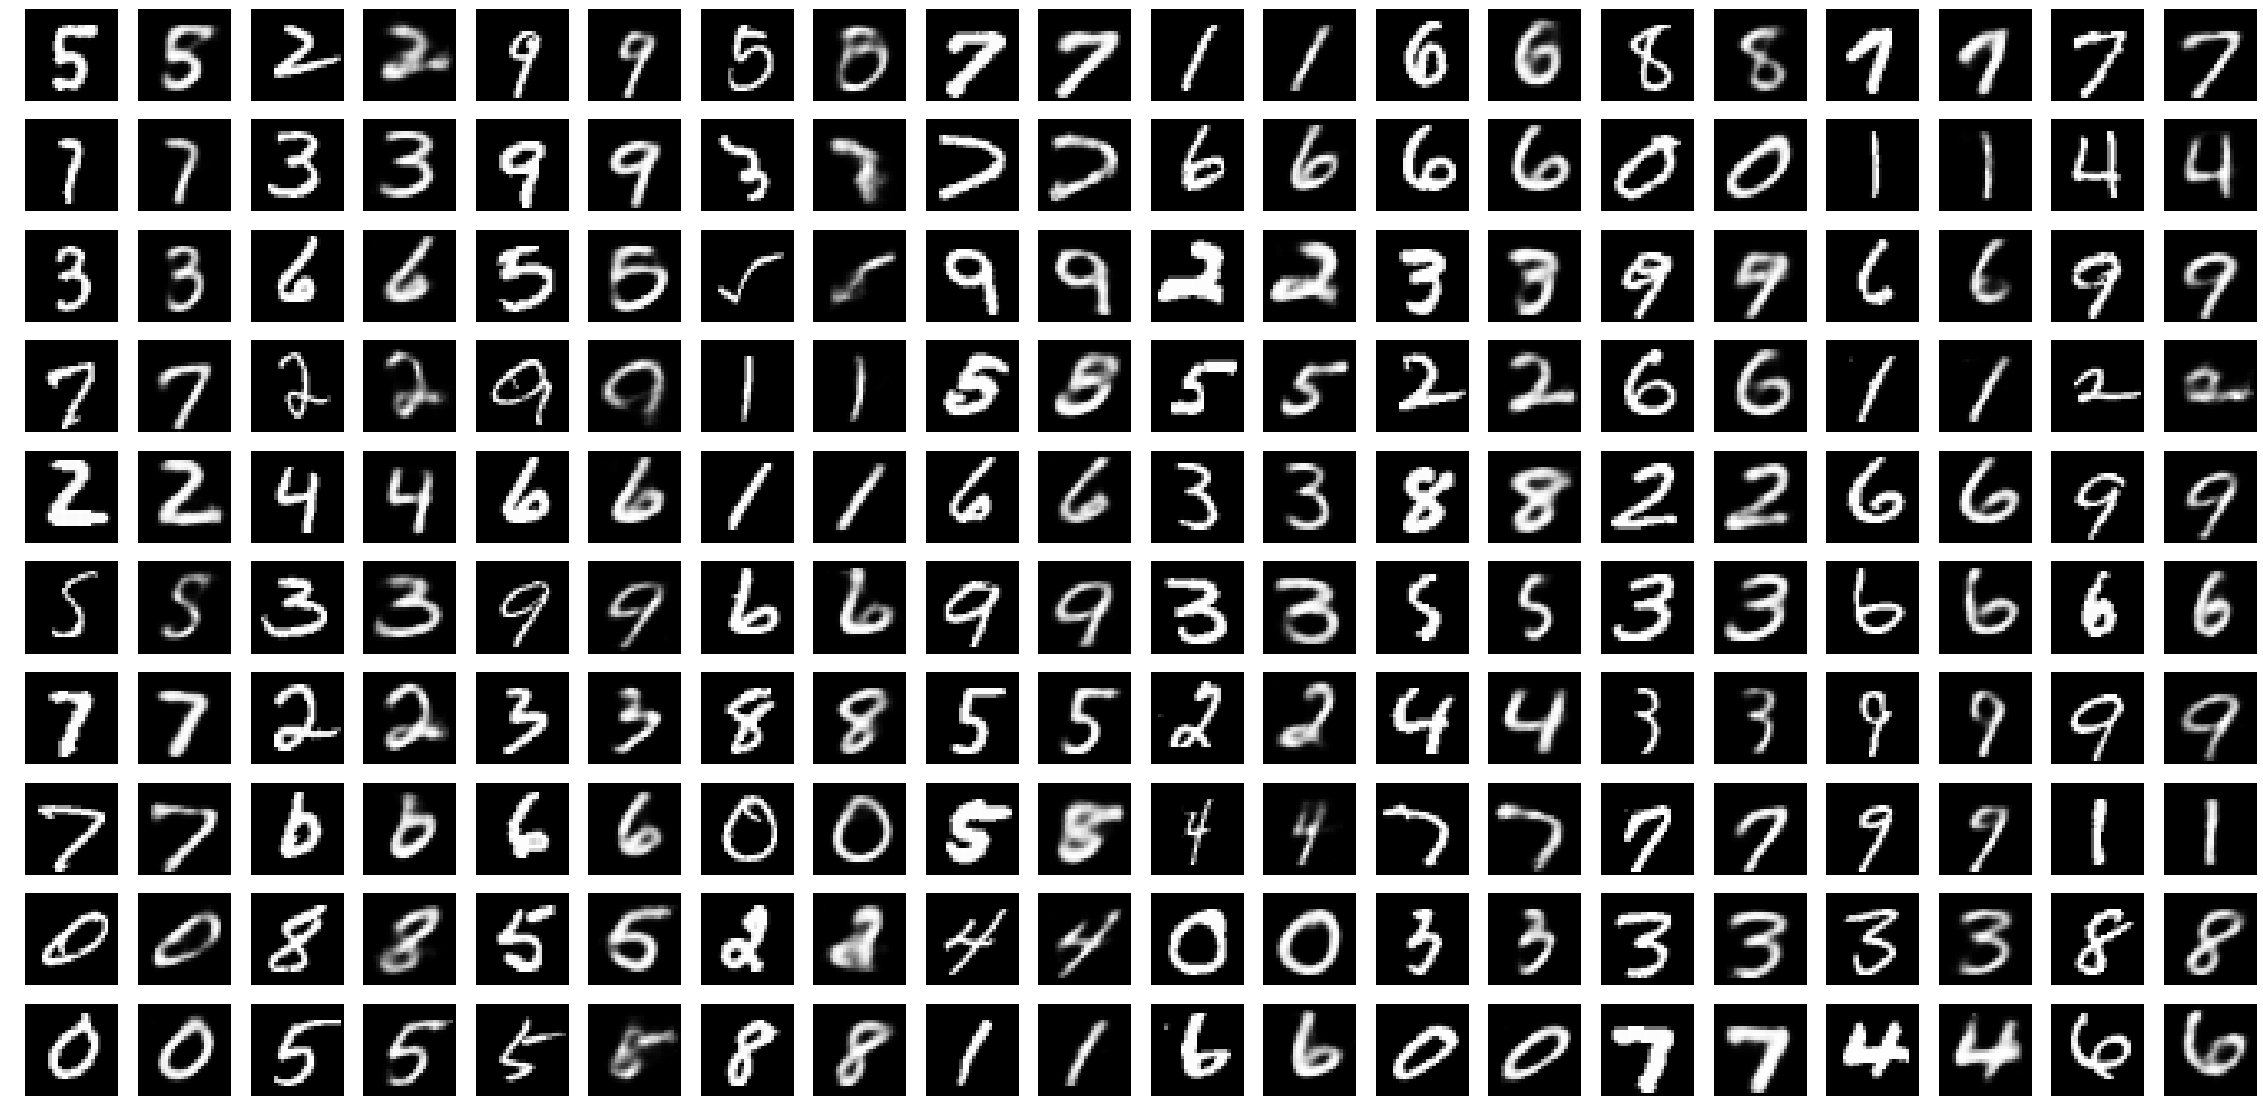

In [13]:
org = new_batch[0][:].reshape((100, 28, 28))
recon = x_estimated[:].reshape((100, 28,28))
# Now we reshape the two arrays and plot them on a figure
print(org.shape, recon.shape)
plt.figure(figsize = (20,40))
f, axx = plt.subplots(10,20, figsize = (40,20))
for i in range(10):
     for j in range(0,20):
         if j%2 ==0:
             axx[i][j].imshow(org[10*i + (j // 2)], cmap = 'gray')
             axx[i][j].axis('off')
         else:
             axx[i][j].imshow(recon[10*i + (j // 2)], cmap = 'gray')
             axx[i][j].axis('off')